In [ ]:
import torch
import torch.nn as nn
import matplotlib.pyplot as plt
import numpy as np
# -----------------------------------------------------------------------------
# Author: Zexiong Wu, Xueyou Li (wuzx58@mail2.sysu.edu.cn, lixueyou@mail.sysu.edu.cn)
# Date: 2024-06-09
# Description: Load PINN model
# Article: https://link.cnki.net/urlid/32.1124.TU.20250926.1432.002
# -----------------------------------------------------------------------------

In [17]:
# Custom neural network
class CustomNetwork(nn.Module):
    def __init__(self, layers, activation=nn.Tanh(), is_TanhShrink=False):
        super().__init__()
        activation_list = [activation] * (len(layers) - 2)
        if is_TanhShrink:
            activation_list[0] = nn.Tanhshrink()
            activation_list[-1] = nn.Tanhshrink()
        self.networks = self.create_network(layers, activation_list)

    # Build the sequential network
    def create_network(self, layers, activation_list):
        network = nn.Sequential()
        for i in range(len(layers)-2):
            network.add_module('linear{}'.format(i+1), nn.Linear(layers[i], layers[i+1]))
            network.add_module('activation{}'.format(i+1), activation_list[i])
        network.add_module('output', nn.Linear(layers[-2], layers[-1]))
        return network
    
    # Forward pass with hard constraint
    def forward(self, inputs_list):
        xN, LpN, MtN, VtN = inputs_list
        inputs_tensor = torch.cat(inputs_list, dim=1)
        outputs_tensor = self.networks(inputs_tensor)
        y = outputs_tensor[:, 0].unsqueeze(1) * MtN + outputs_tensor[:, 1].unsqueeze(1) * VtN
        return y
    
    # Output all required physical quantities
    def outputs(self, input_list):
        '''input_list: [x, Mt, Vt, EI, Lp, m, b0]'''
        x, Mt, Vt, EI, Lp, m, b0 = input_list
        alpha = (m * b0 / EI)**(1 / 5)
        xN = x * alpha
        LpN = Lp * alpha
        VtN = Vt / (EI * alpha**3)
        MtN = Mt / (EI * alpha**2)
        y = self.forward([xN, LpN, MtN, VtN])
        dy = gradients(y, x, 1)
        d2y = gradients(dy, x, 1)
        d3y = gradients(d2y, x, 1)
        d4y = gradients(d3y, x, 1)
        return [y, dy, d2y*EI, d3y*EI, d4y*EI]

# Compute gradients of u with respect to x
def gradients(u, x, order=1):
    if order == 1:
        return torch.autograd.grad(u, x, grad_outputs=torch.ones_like(u),
                                   create_graph=True,
                                   retain_graph=True,
                                   only_inputs=True,)[0]
    else:
        return gradients(gradients(u, x), x, order=order - 1)

# Mean squared error
def MS(equ):
    return torch.mean(equ**2)

In [18]:
# Load model
def load_model(filename):
    model = CustomNetwork(layers=[4] + [50] * 4 + [2], activation=nn.Tanh(), is_TanhShrink=True)
    model.load_state_dict(torch.load(filename + '.pth'))
    model.eval()
    return model
model = load_model('PINN_m_method_pile')

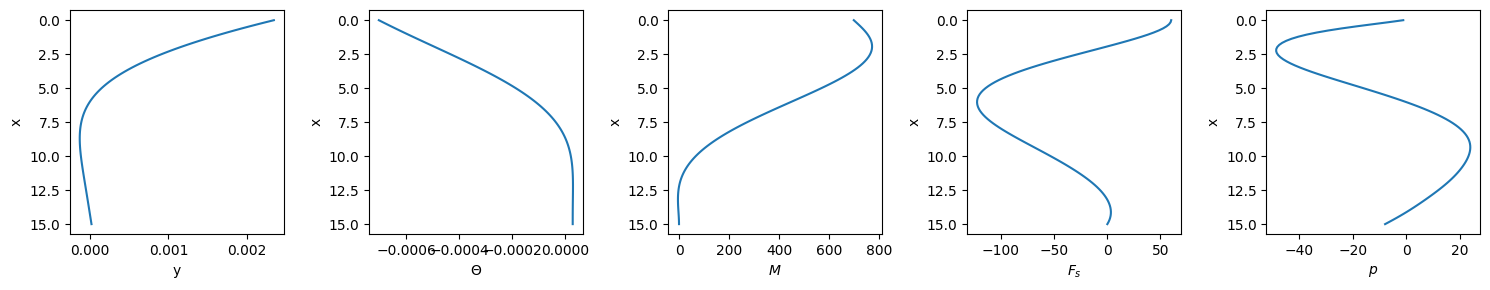

In [19]:
# Predict
Lp = 15
E = 2.8e7
Vt = 60
Mt = 700
D = 1.5
b0 = 2.25
m = 9400

EI = E * (np.pi * D**4) / 64
model.to('cpu')
x = torch.linspace(0, Lp, 100).view(-1, 1).requires_grad_(True)
input_list = [x, Mt*torch.ones_like(x), Vt*torch.ones_like(x), EI*torch.ones_like(x),
              Lp*torch.ones_like(x), m*torch.ones_like(x), b0*torch.ones_like(x)]
output_list = model.outputs(input_list)

plt.figure(figsize=(15, 3))
for i in range(5):
    plt.subplot(1, 5, i+1)
    plt.plot(output_list[i].detach().numpy(), x.detach().numpy())
    plt.gca().invert_yaxis()
    plt.ylabel('x')
    plt.xlabel(['y', '$\Theta$', '$M$', '$F_s$', '$p$'][i])
    plt.tight_layout()
